In [39]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification # To test if RandomForestClassifier is imported correctly
from sklearn.metrics import f1_score
from data_cleaning_utils import filter_columns

In [34]:
df = pd.read_csv('./data/full_data.csv')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126658 entries, 0 to 126657
Data columns (total 45 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   num_acc      126658 non-null  int64  
 1   id_usager    126658 non-null  int64  
 2   id_vehicule  126658 non-null  int64  
 3   place        126658 non-null  int64  
 4   catu         126658 non-null  int64  
 5   grav         126658 non-null  int64  
 6   sexe         126658 non-null  int64  
 7   an_nais      126658 non-null  int64  
 8   trajet       126658 non-null  int64  
 9   secu1        126658 non-null  int64  
 10  secu2        126658 non-null  int64  
 11  secu3        126658 non-null  int64  
 12  locp         126658 non-null  int64  
 13  actp         126658 non-null  int64  
 14  etatp        126658 non-null  int64  
 15  senc         126658 non-null  int64  
 16  catv         126658 non-null  int64  
 17  obs          126658 non-null  int64  
 18  obsm         126658 non-

In [86]:
#Run this to make sure everything works
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)
print(clf.predict([[0, 0, 0, 0]])) #Should display [1]

[1]


# Here we prepare our training data
X -> matrix (n_samples, n_features) \
y -> array (n_samples) with desired output (here i will try with **grav**)

In [40]:
# We samle our training and testing data
dftrain = df.sample(frac=0.7)
dftest = df.merge(dftrain, how='left', indicator=True)
dftest = dftest[dftest['_merge'] == 'left_only']
dftest = filter_columns(dftest, ['_merge'])


# -- Extracting y from dataframe training and creating array X --
yColumn = "grav"
if(dftrain[yColumn].isnull().any()):
    raise ValueError("missing values in column '" + yColumn + "'")
y = dftrain[yColumn].to_list()

# getting all the columns
new_cols = set(dftrain.columns)
# removing the desired column
new_cols.remove(yColumn)
new_cols = list(new_cols)
X = dftrain[new_cols]
X = X.to_numpy()

# -- Same for testing data --
yColumn = "grav"
if(dftest[yColumn].isnull().any()):
    raise ValueError("missing values in column '" + yColumn + "'")
ytest = dftest[yColumn].to_list()

# getting all the columns
new_cols = set(dftest.columns)
# removing the desired column
new_cols.remove(yColumn)
new_cols = list(new_cols)
Xtest = dftest[new_cols]
Xtest = Xtest.to_numpy()

In [6]:
#Here we keep a portion of the data as a testing set to see if our rfc works
x1, x2, x3 = np.array_split(X, 3)
X = np.concatenate([x1, x2])

y1, y2, y3 = np.array_split(y, 3)
y = np.concatenate([y1, y2])

print(len(X))
print(len(y))

84439
84439


# Training the RFC

In [41]:
clf = RandomForestClassifier()
clf.fit(X, y)

RandomForestClassifier()

In [42]:
y_pred = clf.predict(Xtest)
f1 = f1_score(ytest, y_pred, average="weighted")
print(f1) #0.6432440019888556 -> 0.6480447511164154 -> 0.6617

0.6617111026416332


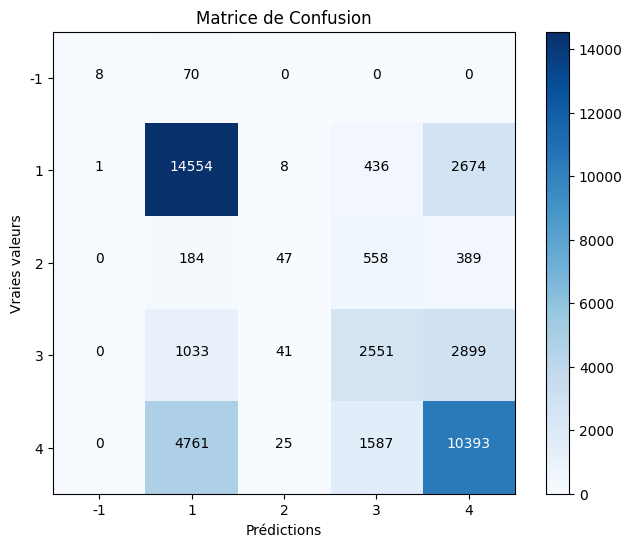

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
import itertools

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(ytest, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de Confusion')
plt.colorbar()

# Ajouter les étiquettes aux axes
classes = np.unique(y)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Ajouter les valeurs dans la matrice
thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.ylabel('Vraies valeurs')
plt.xlabel('Prédictions')
plt.show()